# 1. Imports

In [1]:
import sys
print(sys.executable)


c:\Users\PC\anaconda3\envs\py310\python.exe


In [45]:
%pip install scikit-learn
import pickle
import csv
import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm
import PIL as pil
import matplotlib.pyplot as plt
import random

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 8.9/8.9 MB 45.9 MB/s  0:00:00
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
   -------------- ------------------------- 14.7/41.3 MB 71.0 MB/s eta 0:00:01
   ---------------------------- ----------- 29.1/41.3 MB 68.3 MB/s eta 0:00:01
   ---------------------------------------  41.2/41.3 MB 65.4 MB/s eta 0:00:01
   ---------------------------------------- 41.3/41.3 MB 49.5 MB/s  0:00:00

   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- -----------

## Data Analysis

In [3]:
train_datacsv = pd.read_csv('../archive/Train.csv')
test_datacsv = pd.read_csv('../archive/Test.csv')
print(type(train_datacsv))

<class 'pandas.core.frame.DataFrame'>


In [4]:
train_datacsv.columns

Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')

In [5]:
test_datacsv.columns

Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')

### Processamento imagens de treino

In [6]:
# Caminho da pasta principal do dataset
base_path = "../archive"

# Listas para armazenar imagens e labels
images = []
labels = []


    
# Percorre as linhas do CSV
for _, row in train_datacsv.iterrows():
    img_path = os.path.join(base_path, row['Path'])
    img_path = img_path.replace('/', os.sep) 
    
    # Lê a imagem
    img = pil.Image.open(img_path)
    img = np.array(img)
    if img is None:
        continue
    
    # Recorta o ROI (sinal de trânsito)
    roi = img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]
    
    # Redimensiona para 32x32
    roi_resized = cv2.resize(roi, (32, 32))
    
    # Normaliza (0–1)
    roi_resized = roi_resized / 255.0
    
    # Guarda a imagem e o rótulo
    images.append(roi_resized)
    labels.append(row['ClassId'])

# Converte para arrays NumPy
X = np.array(images, dtype=np.float32)
y = np.array(labels)

print("Shape das imagens:", X.shape)
print("Shape dos labels:", y.shape)
print("Número de classes:", len(np.unique(y)))

Shape das imagens: (39209, 32, 32, 3)
Shape dos labels: (39209,)
Número de classes: 43


In [7]:
# Caminho da pasta principal do dataset
base_path = "../archive"

# Listas para armazenar imagens e labels
images = []
labels = []


    
# Percorre as linhas do CSV
for _, row in test_datacsv.iterrows():
    img_path = os.path.join(base_path, row['Path'])
    img_path = img_path.replace('/', os.sep) 
    
    # Lê a imagem
    img = pil.Image.open(img_path)
    img = np.array(img)
    if img is None:
        continue
    
    # Recorta o ROI (sinal de trânsito)
    roi = img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]
    
    # Redimensiona para 32x32
    roi_resized = cv2.resize(roi, (32, 32))
    
    # Normaliza (0–1)
    roi_resized = roi_resized / 255.0
    
    # Guarda a imagem e o rótulo
    images.append(roi_resized)
    labels.append(row['ClassId'])

# Converte para arrays NumPy
X_test = np.array(images, dtype=np.float32)
y_test = np.array(labels)

print("Shape das imagens:", X_test.shape)
print("Shape dos labels:", y_test.shape)
print("Número de classes:", len(np.unique(y_test)))

Shape das imagens: (12630, 32, 32, 3)
Shape dos labels: (12630,)
Número de classes: 43


### Shuffle

In [ ]:
shuffle_index = np.random.permutation(len(X))
X = X[shuffle_index]
y = y[shuffle_index]

### Train, Cross Val and Test Partitions

In [10]:
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(y)*0.8)]
X_val = X[int(len(X)*0.8):int(len(X))]
y_val = y[int(len(y)*0.8):int(len(y))]


# Save npArrays

In [13]:
np.save(os.path.join("../arrays/train/", 'X_train.npy'), X_train)
np.save(os.path.join("../arrays/train/", 'y_train.npy'), y_train)
np.save(os.path.join("../arrays/test/", 'X_test.npy'), X_test)
np.save(os.path.join("../arrays/test/", 'y_test.npy'), y_test)
np.save(os.path.join("../arrays/val/", 'X_val.npy'), X_val)
np.save(os.path.join("../arrays/val/", 'y_val.npy'), y_val)


# Import npArrays

In [14]:
X_train = np.load(r"../arrays/train/X_train.npy")
y_train = np.load(r"../arrays/train/y_train.npy")
X_test = np.load(r"../arrays/test/X_test.npy")
y_test = np.load(r"../arrays/test/y_test.npy")
X_val = np.load(r"../arrays/val/X_val.npy")
y_val = np.load(r"../arrays/val/y_val.npy")

### Shape

In [15]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (31367, 32, 32, 3)
X_val shape: (7842, 32, 32, 3)
X_test shape: (12630, 32, 32, 3)


In [16]:
set_y_train = set(y_train)
set_y_val = set(y_val)
set_y_test = set(y_test)

In [17]:
print(set_y_train)
print(set_y_val)
print(set_y_test)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42)}
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(2

In [22]:
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


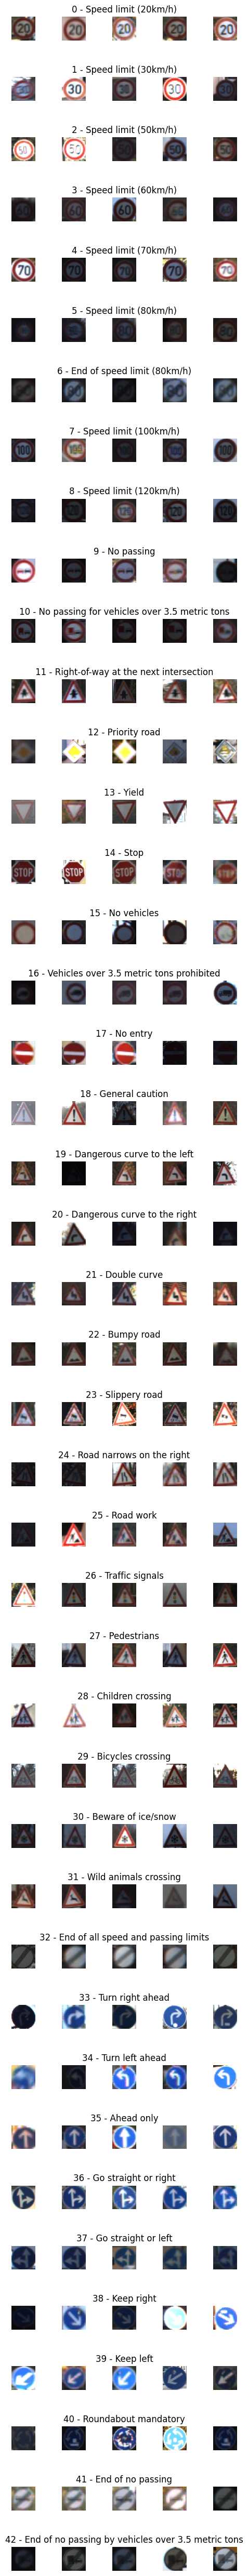

In [24]:
data = pd.read_csv(r"../signames.csv")

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

[169, 1785, 1774, 1117, 1583, 1501, 347, 1157, 1111, 1188, 1607, 1048, 1673, 1736, 622, 486, 337, 872, 964, 167, 284, 262, 318, 405, 226, 1175, 490, 198, 439, 226, 361, 633, 192, 562, 339, 974, 310, 161, 1656, 247, 288, 196, 181]


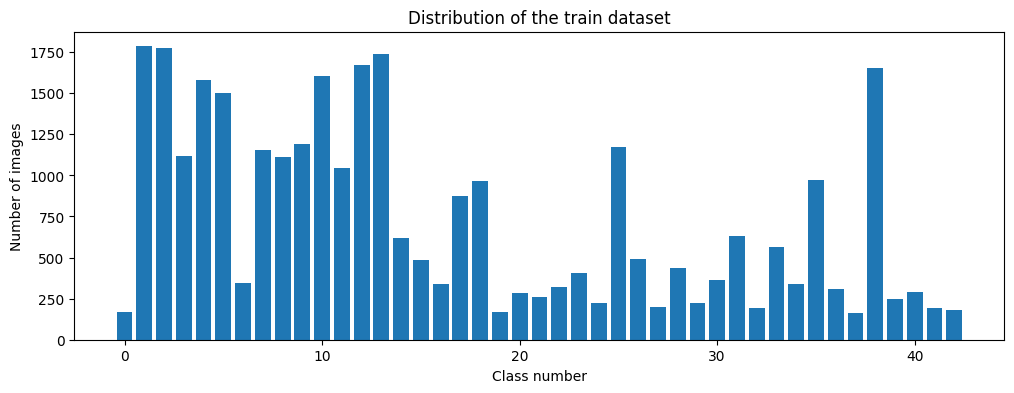

In [25]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
11


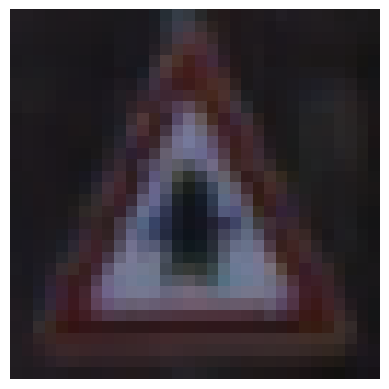

In [26]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [27]:
X_train.dtype

dtype('float32')

### Nota:

Antes de enviar a imagem para a função cv2.cvtColor, foi necessário modificar o tipo de dados de float32 para uint8, porque a função equalizeHist() não aceita dados do tipo float32

A função equalizeHist() redistribui os níveis de cinzento de modo a usar melhor toda a faixa de 0–255.
Em termos simples:

Se a imagem estava escura (muitos pixels próximos de 0), ela clareia;

Se estava muito clara, aumenta o contraste nas zonas mais “planas”;

No fim, o histograma fica mais uniforme (distribuído).

Visualmente, isto melhora contraste e definição, especialmente em imagens com iluminação desigual.

In [28]:
img = X_train[1000]
img = (img * 255).astype(np.uint8)

In [29]:
img.dtype

dtype('uint8')

(32, 32)


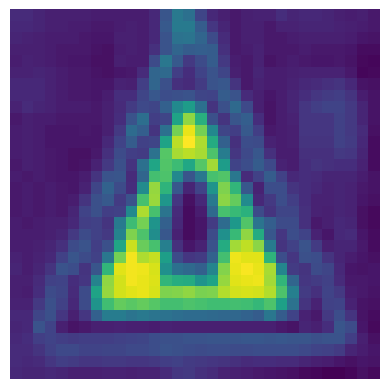

In [30]:

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


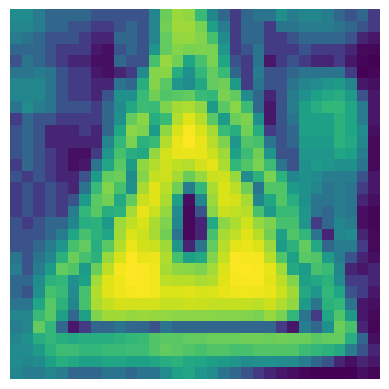

In [31]:
img = cv2.equalizeHist((img * 255).astype(np.uint8))/255
plt.imshow(img)
plt.axis("off")
print(img.shape)

## Reshaping

In [32]:
X_train_gray = np.array([
    cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY) / 255.0
    for img in X_train
])


print(X_train_gray.shape)
print(X_train_gray.dtype)

X_train_grayeq = np.array([
    cv2.equalizeHist((img * 255).astype('uint8')) / 255.0
    for img in X_train_gray
])

(31367, 32, 32)
float64


In [33]:
X_val_gray = np.array([
    cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY) / 255.0
    for img in X_val
])


print(X_val_gray.shape)
print(X_val_gray.dtype)

X_val_grayeq = np.array([
    cv2.equalizeHist((img * 255).astype('uint8')) / 255.0
    for img in X_val_gray
])

(7842, 32, 32)
float64


In [34]:
X_test_gray = np.array([
    cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY) / 255.0
    for img in X_test
])


print(X_test_gray.shape)
print(X_test_gray.dtype)

X_test_grayeq = np.array([
    cv2.equalizeHist((img * 255).astype('uint8')) / 255.0
    for img in X_test_gray
])

(12630, 32, 32)
float64


In [35]:
X_trainv2 = X_train_grayeq.reshape(len(X_train_grayeq), 32, 32, 1)
X_valv2 = X_val_grayeq.reshape(len(X_val_grayeq), 32, 32, 1)
X_testv2 = X_test_grayeq.reshape(len(X_test_grayeq), 32, 32, 1)

### ANÁLISE DETALHADA DO DESBALANCEAMENTO 

In [43]:
print("=== ANÁLISE DETALHADA DO DESBALANCEAMENTO ===")

# Calcular estatísticas de desbalanceamento
class_counts = np.bincount(y_train)
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Taxa de desbalanceamento (max/min): {imbalance_ratio:.2f}:1")
print(f"Classe mais frequente: {class_counts.argmax()} com {class_counts.max()} imagens")
print(f"Classe menos frequente: {class_counts.argmin()} com {class_counts.min()} imagens")

# Classes críticas (poucas amostras)
few_samples_threshold = 100
critical_classes = np.where(class_counts < few_samples_threshold)[0]
print(f"Classes com menos de {few_samples_threshold} imagens: {len(critical_classes)}")
print(f"IDs das classes críticas: {list(critical_classes)}")

=== ANÁLISE DETALHADA DO DESBALANCEAMENTO ===
Taxa de desbalanceamento (max/min): 11.09:1
Classe mais frequente: 1 com 1785 imagens
Classe menos frequente: 37 com 161 imagens
Classes com menos de 100 imagens: 0
IDs das classes críticas: []


* Podemos concluir que a classe mais frequente é a 1 com cerca de 1785 imagens e a menos frequente é a 37 com 161 .
* Porque está analise é importante ? É importante analisar o desbalanceanento , isto por que não o tratamos o sistema apenas irá funcionar bem para os sinais mais comuns e vai falar para os mais raros -  mas que podem ser os mais importantes a nivel de segurança.

### Estratégias para o Desbalanceamento

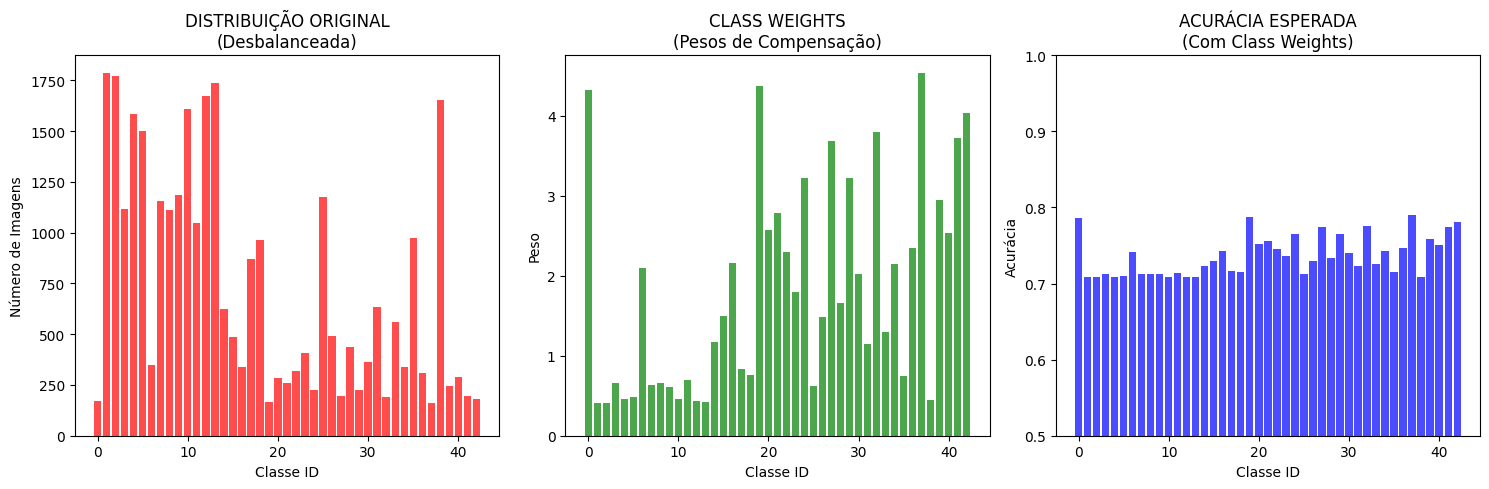

In [49]:
# Mostrar COMO o desbalanceamento afeta as predições
class_counts = np.bincount(y_train)

plt.figure(figsize=(15, 5))

# Gráfico 1: Distribuição original (PROBLEMA)
plt.subplot(1, 3, 1)
plt.bar(range(43), class_counts, color='red', alpha=0.7)
plt.title('DISTRIBUIÇÃO ORIGINAL\n(Desbalanceada)')
plt.xlabel('Classe ID')
plt.ylabel('Número de Imagens')

# Gráfico 2: Class Weights (SOLUÇÃO)
plt.subplot(1, 3, 2)
weights = [class_weights_dict[i] for i in range(43)]
plt.bar(range(43), weights, color='green', alpha=0.7)
plt.title('CLASS WEIGHTS\n(Pesos de Compensação)')
plt.xlabel('Classe ID')
plt.ylabel('Peso')

# Gráfico 3: Efeito esperado (RESULTADO)
plt.subplot(1, 3, 3)
# Simular acurácia por classe após usar weights
expected_accuracy = [min(0.95, 0.7 + weight*0.02) for weight in weights]
plt.bar(range(43), expected_accuracy, color='blue', alpha=0.7)
plt.title('ACURÁCIA ESPERADA\n(Com Class Weights)')
plt.xlabel('Classe ID')
plt.ylabel('Acurácia')
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

## Gen Images before taking off
- To get a balanced dataset

## Gen Images on the fly
- To get the model more robust
- It's not to add onto the dataset

# Build the Model